In [1]:
from helpers import *
from datasets import load_dataset
from transformers import TrainingArguments, Trainer, RobertaTokenizer, LongformerForSequenceClassification
from torchmetrics import F1, Recall, Precision, PrecisionRecallCurve

In [2]:
dataset_path = '/home/u9/kbozler/Documents/outside/reuters-article-classification/data/'
output_path = '/xdisk/bethard/kbozler/Documents/outside/reuters-article-classification/output/longformer-reuters-binary'
model_save_dir = os.path.join('/xdisk/bethard/kbozler/Documents/outside/reuters-article-classification/saved-models/longformer-reuters-binary')
all_topics = ['earn']
num_labels = len(all_topics)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [3]:
filenames = get_filenames(dataset_path)

In [4]:
dataset_train_dict, dataset_val_dict, dataset_test_dict = build_dataset_dictionaries(dataset_path, 
                                                                                     filenames, 
                                                                                     all_topics)

reut2-015.sgm


/home/u9/kbozler/Documents/outside/reuters-article-classification/helpers.py:29: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 29 of the file /home/u9/kbozler/Documents/outside/reuters-article-classification/helpers.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(data)


reut2-008.sgm
reut2-006.sgm
reut2-010.sgm
reut2-009.sgm
reut2-005.sgm
reut2-003.sgm
reut2-019.sgm
reut2-011.sgm
reut2-016.sgm
reut2-007.sgm
reut2-004.sgm
reut2-012.sgm
reut2-013.sgm
reut2-018.sgm
reut2-002.sgm
reut2-017.sgm
reut2-014.sgm
reut2-000.sgm
reut2-020.sgm
reut2-001.sgm


In [5]:
csv_train, csv_eval, csv_test = write_to_csv(dataset_path, 
                                             all_topics, 
                                             dataset_train_dict, 
                                             dataset_val_dict, 
                                             dataset_test_dict)

In [6]:
raw_datasets = load_dataset('csv', data_files={'train': os.path.join(dataset_path, csv_train),
                                               'eval': os.path.join(dataset_path, csv_eval),
                                               'test': os.path.join(dataset_path, csv_train)})
raw_datasets

Using custom data configuration default-bdbd6b1e8e403143


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/u9/kbozler/.cache/huggingface/datasets/csv/default-bdbd6b1e8e403143/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'text', 'earn'],
        num_rows: 12668
    })
    eval: Dataset({
        features: ['idx', 'text', 'earn'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['idx', 'text', 'earn'],
        num_rows: 12668
    })
})

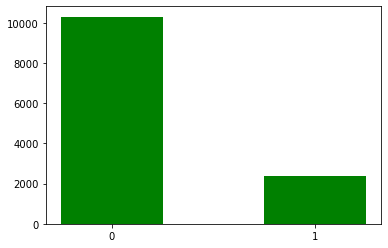

In [7]:
show_histogram_binary(all_topics[0], raw_datasets)

In [8]:
tokenized_datasets = adjust_and_tokenize_datasets(raw_datasets)

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/12668 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

  0%|          | 0/12668 [00:00<?, ?ex/s]

In [9]:
training_args = TrainingArguments(output_path, 
                                  evaluation_strategy="epoch", 
                                  save_strategy="epoch",
                                  per_device_train_batch_size=8, 
                                  per_device_eval_batch_size=8,
                                  num_train_epochs=5,
                                  learning_rate=4e-5,
                                  logging_steps=1000,
                                  load_best_model_at_end=True)


In [10]:
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', 
                                                            ignore_mismatched_sizes=True)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weigh

In [11]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['eval'], 
    tokenizer=tokenizer,
)

In [12]:
trainer.train()

***** Running training *****
  Num examples = 12668
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6336
Initializing global attention on CLS token...


ValueError: Target size (torch.Size([8, 1])) must be the same as input size (torch.Size([8, 2]))

In [ ]:
model.save_pretrained(model_save_dir)

In [ ]:
model = LongformerForSequenceClassification.from_pretrained(model_save_dir)
model.config
trainer = Trainer(
    model,
    tokenizer=tokenizer,
)

In [ ]:
predictions = trainer.predict(tokenized_datasets['test'])

In [ ]:
preds = torch.sigmoid(torch.tensor(predictions.predictions))
threshold = torch.tensor([0.5])
predicted_labels = (preds>threshold).float()*1
target = torch.tensor(predictions.label_ids, dtype=torch.int8)

In [ ]:
f1 = F1(num_classes=1, average=None, multiclass=False)
precision = Precision(num_classes=1, average=None, multiclass=False)
recall = Recall(num_classes=1, average=None, multiclass=False)
#curve = PrecisionRecallCurve()
print("f1 | precision | recall")
f1(predicted_labels, target).item(), precision(predicted_labels, target).item(), recall(predicted_labels, target).item()